# <b> House Price Predictor </b>

# Data Processing

### Importing Libraries and uploading data file

In [46]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns 

Asking user to upload data file. <br>
Upload housingdata.csv file here.

In [47]:
# # INSTRUCTION:  Remove comment from below two lines if you need to upload the dataset

# from google.colab import files
# uploaded = files.upload()

<u>Accessing the data </u><br>

The datasets are sourced from [kaggle](https://kaggle.com/ruchi798/housing-prices-in-metropolitan-areas-of-india).
There are six seperate datasets for six metro cities of India. housingdata.csv is a merged csv file for all the six

In [48]:
df1 = pd.read_csv("housingdata.csv")
df1.head()

,Price,City,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,RainWaterHarvesting,IndoorGames,ShoppingMall,Intercom,SportsFacility,ATM,ClubHouse,School,24X7Security,PowerBackup,CarParking,StaffQuarter,Cafeteria,MultipurposeRoom,Hospital,WashingMachine,Gasconnection,AC,Wifi,Children'splayarea,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
0,30000000,Bangalore,3340,JP Nagar Phase 1,4,0,1,1,1,1,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
1,7888000,Bangalore,1045,Dasarahalli on Tumkur Road,2,0,0,1,1,1,1,1,1,0,0,1,0,1,0,1,1,1,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0
2,4866000,Bangalore,1179,Kannur on Thanisandra Main Road,2,0,0,1,1,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
3,8358000,Bangalore,1675,Doddanekundi,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,6845000,Bangalore,1670,Kengeri,3,0,1,1,1,1,1,1,1,0,1,1,0,1,0,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0


In [49]:
df1.shape

(32963, 41)

The data has 41 columns and 32958 rows.

### Data Cleaning

Converting the column names to lowercase and making a column 'bhk' instead of 'no. of bedrooms' for simplicity.

In [50]:
df1.columns= df1.columns.str.lower() #converts to lowercase
df1['bhk'] = df1['no. of bedrooms']  #creates col bhk a copy of no. of bedrooms
df2 = df1.drop(['no. of bedrooms'], axis='columns') #deletes no. of bedrooms
df2.head()

,price,city,area,location,resale,maintenancestaff,gymnasium,swimmingpool,landscapedgardens,joggingtrack,rainwaterharvesting,indoorgames,shoppingmall,intercom,sportsfacility,atm,clubhouse,school,24x7security,powerbackup,carparking,staffquarter,cafeteria,multipurposeroom,hospital,washingmachine,gasconnection,ac,wifi,children'splayarea,liftavailable,bed,vaastucompliant,microwave,golfcourse,tv,diningtable,sofa,wardrobe,refrigerator,bhk
0,30000000,Bangalore,3340,JP Nagar Phase 1,0,1,1,1,1,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,4
1,7888000,Bangalore,1045,Dasarahalli on Tumkur Road,0,0,1,1,1,1,1,1,0,0,1,0,1,0,1,1,1,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,2
2,4866000,Bangalore,1179,Kannur on Thanisandra Main Road,0,0,1,1,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2
3,8358000,Bangalore,1675,Doddanekundi,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3
4,6845000,Bangalore,1670,Kengeri,0,1,1,1,1,1,1,1,0,1,1,0,1,0,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,3


Listing the count of each individual location in descending order

In [51]:
df3 = df2.copy()
location_count = df3.groupby('location')['location'].agg('count').sort_values(ascending=False)
#Groups the data by location value and arrange them is descending order. Saves the order as location_count
location_count

location
Noida                           761
New Town                        711
Kharghar                        681
Thane West                      577
Mira Road East                  481
                               ... 
Mansoorabad                       1
Mansarovar garden                 1
Manpada near Tiku ji ni wadi      1
Mangadu                           1
1 Lane Johri Farm                 1
Name: location, Length: 1776, dtype: int64

Many locations have very less amount of datasets which can cause inaccuracy in our model. Thus, we set the threshold as <=10, replacing the locations having frequency below threshold with 'other'


In [52]:
location_below_th = location_count[location_count<=10]   #Saves <=10 values in location_below_th
location_below_th

location
Vanagaram                       10
Kalamboli                       10
Periyapanicheri                 10
Dhakuria Station Road           10
Thaiyur                         10
                                ..
Mansoorabad                      1
Mansarovar garden                1
Manpada near Tiku ji ni wadi     1
Mangadu                          1
1 Lane Johri Farm                1
Name: location, Length: 1268, dtype: int64

In [53]:
#Setting location value to 'other' if it is in location_below_th
df3.location = df3.location.apply(lambda x: 'other' if x in location_below_th else x)
len(df3.location.unique())

509

In the dataset available, many rows have missing data. The data not available is, for some reason, denoted by '9'. <br>
To get an accurate model, it is better if we remove the rows which have 9 as values for amenities' columns.

In [54]:
df3.drop(df3.index[df3['indoorgames'] == 9], inplace=True) #Removes rows with indoorgames value as 9
df3.shape

(10093, 41)

### Feature Engineering

Making a feature for price per square feet - 'price_psqt'. This feature would be useful to determine outliers for our linear models.

In [55]:
df3['price_psqt'] = (df3['price']/df3['area'])
df3.head()

,price,city,area,location,resale,maintenancestaff,gymnasium,swimmingpool,landscapedgardens,joggingtrack,rainwaterharvesting,indoorgames,shoppingmall,intercom,sportsfacility,atm,clubhouse,school,24x7security,powerbackup,carparking,staffquarter,cafeteria,multipurposeroom,hospital,washingmachine,gasconnection,ac,wifi,children'splayarea,liftavailable,bed,vaastucompliant,microwave,golfcourse,tv,diningtable,sofa,wardrobe,refrigerator,bhk,price_psqt
0,30000000,Bangalore,3340,JP Nagar Phase 1,0,1,1,1,1,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,4,8982.035928
1,7888000,Bangalore,1045,Dasarahalli on Tumkur Road,0,0,1,1,1,1,1,1,0,0,1,0,1,0,1,1,1,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,2,7548.325359
2,4866000,Bangalore,1179,Kannur on Thanisandra Main Road,0,0,1,1,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2,4127.226463
3,8358000,Bangalore,1675,Doddanekundi,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,4989.850746
4,6845000,Bangalore,1670,Kengeri,0,1,1,1,1,1,1,1,0,1,1,0,1,0,1,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,3,4098.802395


### Data Visualization and outlier handling



Plotting plots with city variations.

In [56]:
df4 = df3.copy()

def plot_bycity(col, title):
  #Defines a city wise catplot of 'col' given as input
  ax = sns.catplot(x='city', y=col, data=df4, jitter = 0.4, height =4, aspect =2)
  ax.fig.suptitle(title, fontsize=15);


Variation of Housing Area

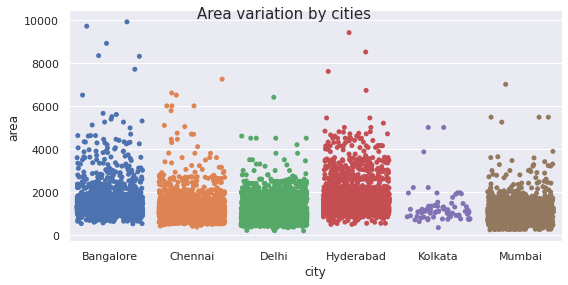

In [57]:
plot_bycity('area', 'Area variation by cities')

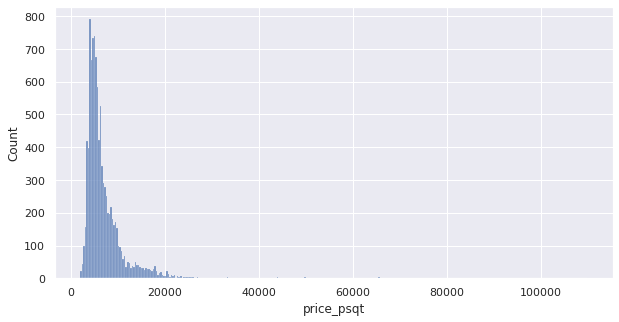

In [58]:
plt.figure(figsize=(10,5))
sns.histplot(df4.price_psqt)  #histogram of price per square feet count by cities.

There seems to be many outlier in price per square feet data, we need to remove the outliers.

In [59]:
df4.price_psqt.describe()

count     10093.000000
mean       7121.729387
std        4977.883800
min        2000.000000
25%        4513.750000
50%        5699.693565
75%        8004.509583
max      109950.522265
Name: price_psqt, dtype: float64

In [60]:
def remove_outliers(df):
  #Retains data only in specified range (embedded into function. 300-25,000 here)
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        reduced_df = subdf[(subdf.price_psqt>(300)) & (subdf.price_psqt<=(25000))] #retains necessary values
        df_out = pd.concat([df_out,reduced_df],ignore_index=True) #ignoring other values
    return df_out
df5 = remove_outliers(df3)
df5.shape

(10000, 42)

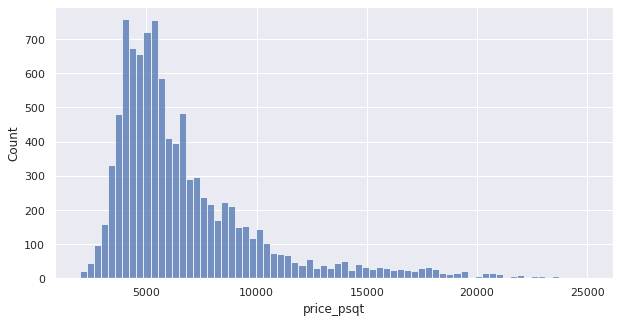

In [61]:
plt.figure(figsize=(10,5))
sns.histplot(df5.price_psqt)   #histograph pf df5.price_psqt

We now have a bell shaped graph with values < 25,000 and >300 suitable for modeling

We shall now explore BHK variations and eliminate outliers.

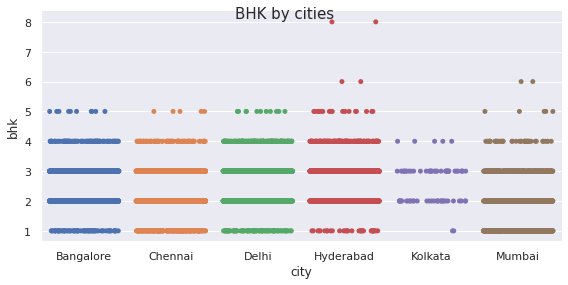

In [62]:
plot_bycity('bhk', 'BHK by cities')

We shall remove bhk values >5 (i.e. 6, 7 and 8) as the data is very limited in such cases.

In [63]:
df6 = df5[df5.bhk<6]   #takes only bhk<6 values in df6
df6.shape

(9995, 42)

The variation of dependent variable - 'House Price'

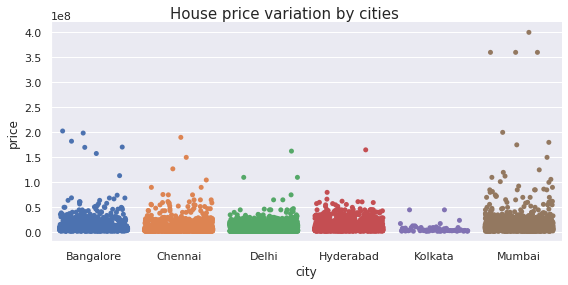

In [64]:
plot_bycity('price', 'House price variation by cities')

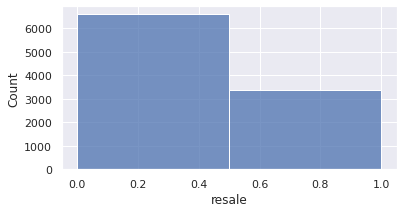

In [65]:
plt.figure(figsize=(6,3))
sns.histplot(data=df6.resale, binwidth=0.5)
#Values are just 0 and 1

We shall now drop price_psqt column

In [66]:
df7 = df6.drop(['price_psqt'], axis='columns')

Converting the price column in lakh rupees

In [67]:
df81 = df7.copy()
df81.price = df7.price/100000

We have a lot of parametere, to explore their relevance, we shall draw a correlation matrix heatmap using sns

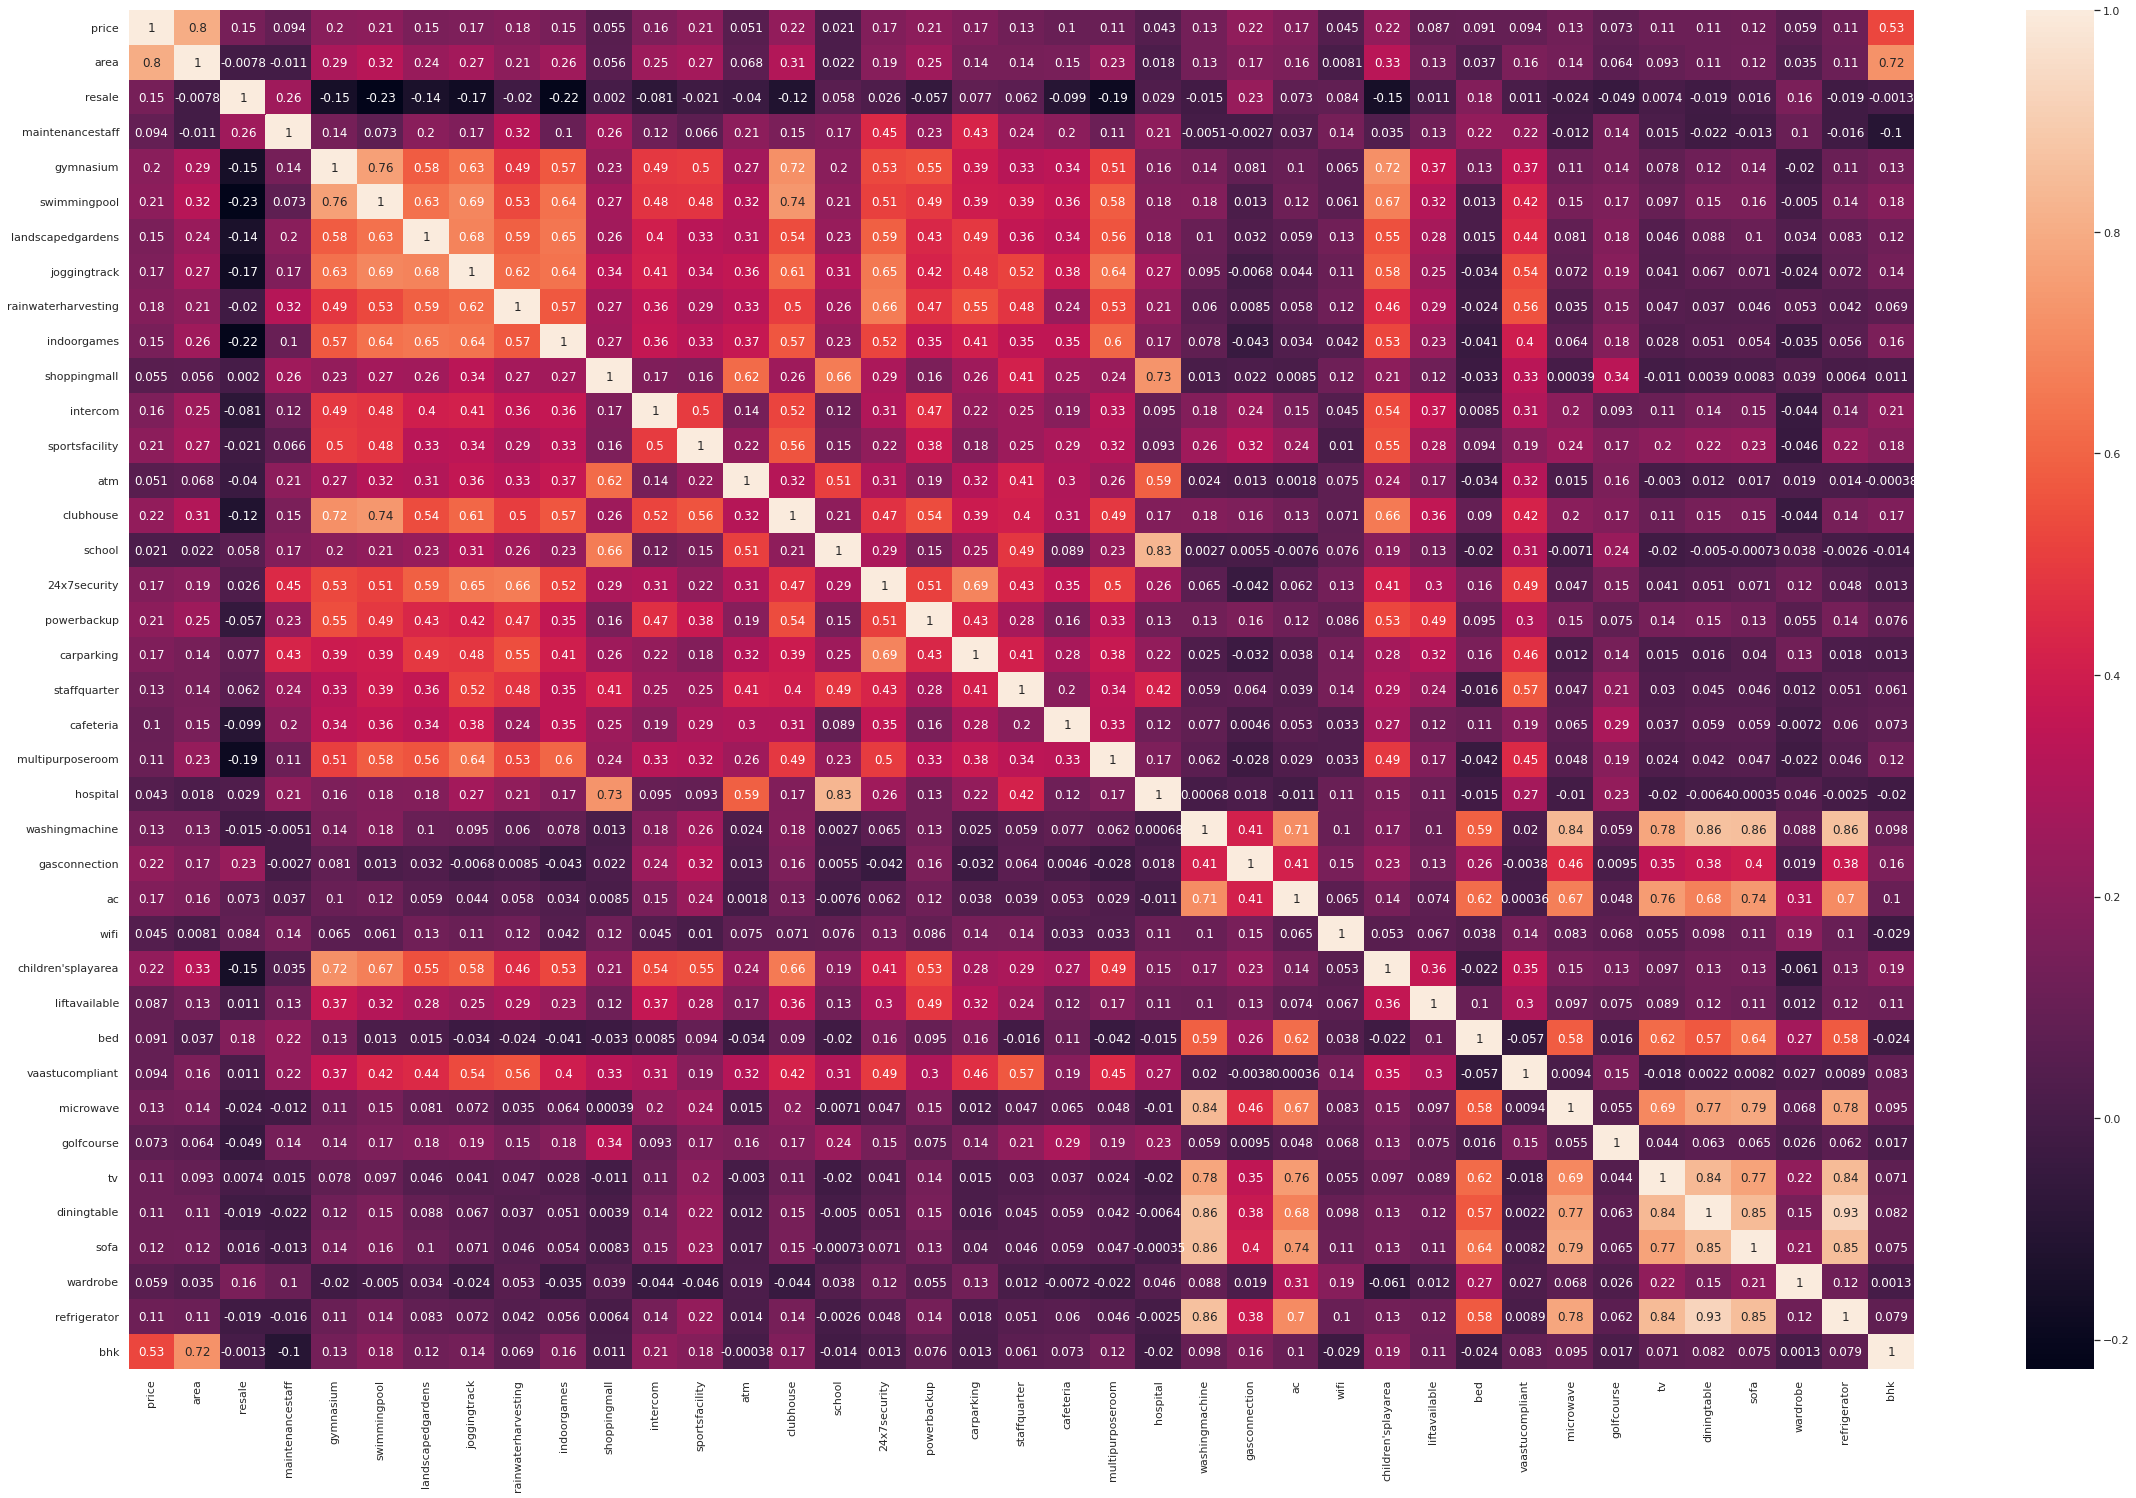

In [68]:
sns.set(rc = {'figure.figsize':(40,25)}) #Defines size
sns.heatmap(df81.corr(), annot=True)

As we can observe, majjority of the parameters have a little corelation with 'price'. We shall filter out parameters with value < 0.15 and parameters of little value to the end-user.

In [69]:
df8 = df81.drop(['maintenancestaff', 'shoppingmall', 'atm', 'school', 'hospital', 'wifi', 'liftavailable', 'vaastucompliant', 'golfcourse', 'wardrobe', 'staffquarter', 'cafeteria', 'multipurposeroom', 'washingmachine', 'microwave', 'tv', 'diningtable', 'sofa', 'refrigerator', "children'splayarea", 'resale', 'bed', 'landscapedgardens', 'joggingtrack', 'rainwaterharvesting', 'indoorgames', 'intercom', '24x7security', 'carparking'], axis='columns')
df8.head()

,price,city,area,location,gymnasium,swimmingpool,sportsfacility,clubhouse,powerbackup,gasconnection,ac,bhk
0,28.0,Chennai,560,Adambakkam,0,0,0,0,0,0,0,1
1,80.0,Chennai,1000,Adambakkam,0,0,0,0,0,0,0,2
2,100.0,Chennai,1293,Adambakkam,0,0,0,0,0,0,0,3
3,107.0,Chennai,1355,Adambakkam,0,0,0,0,0,0,0,3
4,107.0,Chennai,1355,Adambakkam,0,0,0,0,1,0,0,3


In [70]:
df8.shape #Only 12 columns remaining.

(9995, 12)

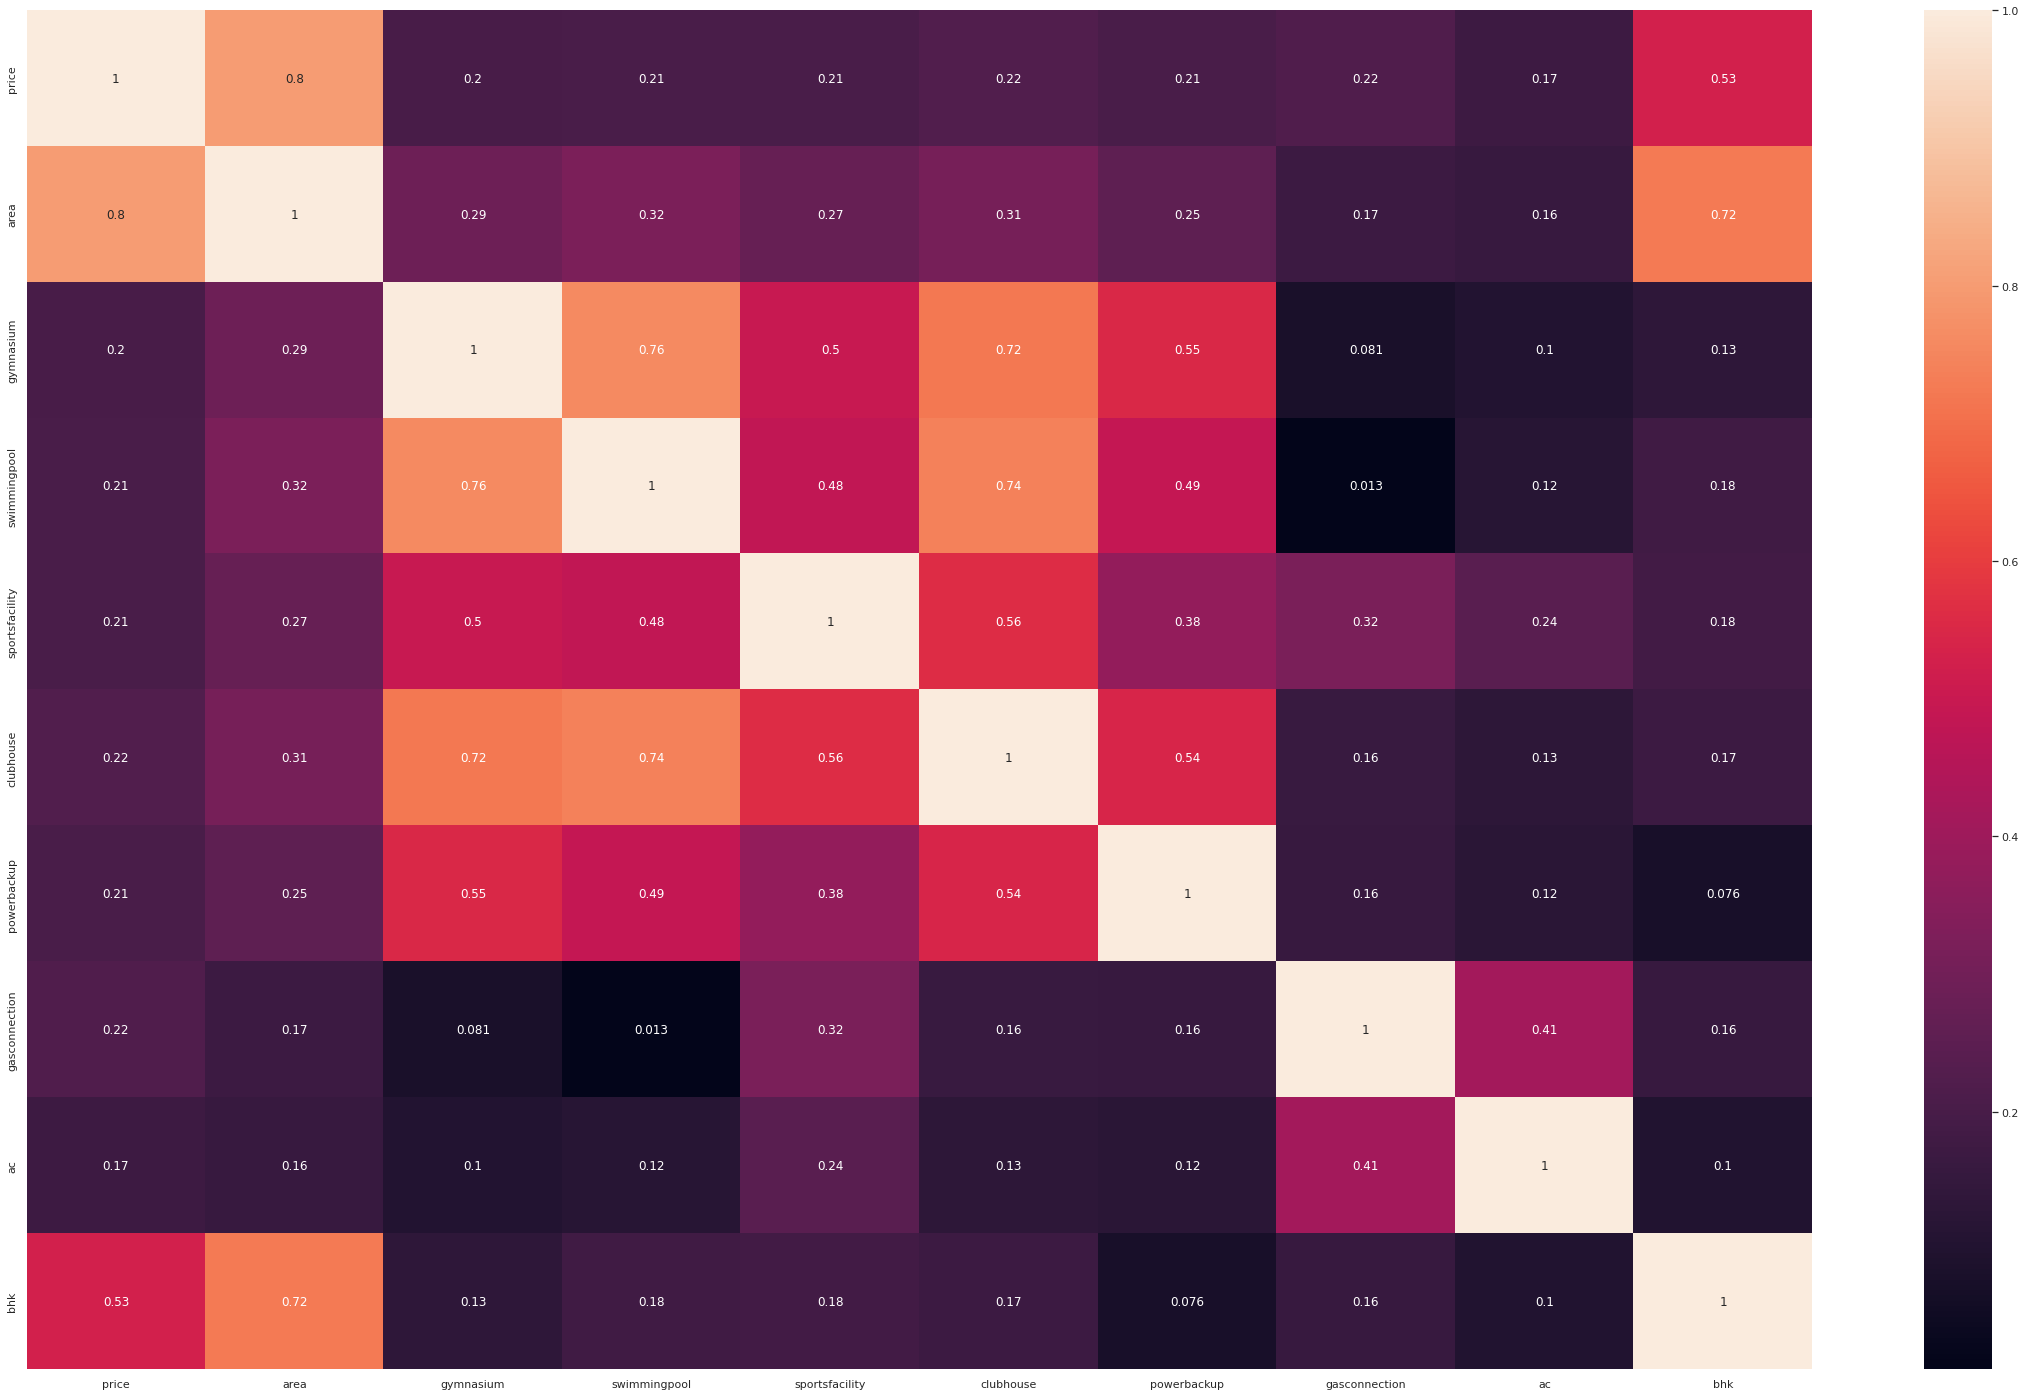

In [71]:
# New Correlation HeatMap
sns.set(rc = {'figure.figsize':(40,25)})
sns.heatmap(df8.corr(), annot=True)

This (df8) is our final dataset. We shall proceed to develop the machine learning model.

#ML Model Developement

### Preparing Data

We will be using One Hot Encoding mechanism to deal with location names.

In [72]:
dummies = pd.get_dummies(df8.location)  #Converts location values into features.
dummies.head()

,Adambakkam,Adibatla,Adyar,Airoli,Alaknanda,Alwal,Alwarpet,Ambattur,Ambernath East,Ambernath West,Aminpur,Anagalapura Near Hennur Main Road,Andheri,Andheri East,Anekal City,Anjanapura,Anna Nagar,Appa Junction,Appa Junction Peerancheru,Ashok Nagar,Attapur,Attibele,Avadi,Avalahalli Off Sarjapur Road,Ayanambakkam,Ayapakkam,BTM Layout,Bachupally,Bachupally Road,Badlapur East,Baguiati,Balanagar,Banashankari,Banaswadi,Bandlaguda Jagir,Banjara Hills,Barasat,Beeramguda,Begumpet,Begur,...,Thoraipakkam,Thoraipakkam OMR,Tiruvottiyur,Toli Chowki,Tollygunge,Ullagaram,Ultadanga,Ulwe,Uttam Nagar,Uttarahalli,Uttarahalli Hobli,Uttarpara Kotrung,Vadapalani,Valasaravakkam,Vandalur,Varthur,Vasai,Vasai West,Vasai east,Vasant Kunj,Velachery,Velappanchavadi,Vengaivasal,Virar,Virar East,Virar West,Virugambakkam,Wadala,Wadala East Wadala,West Marredpally,West Tambaram,Whitefield,Whitefield Hope Farm Junction,Worli,Yelahanka,mumbai,nawada,other,south dum dum,tambaram west
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [73]:
#Drops 'other' column and appends dummies into our dataframe
df9 = pd.concat([df8, dummies.drop('other', axis="columns",errors="ignore")], axis='columns')
df10 = df9.drop('location', axis='columns') #drops location column
df10.head()

,price,city,area,gymnasium,swimmingpool,sportsfacility,clubhouse,powerbackup,gasconnection,ac,bhk,Adambakkam,Adibatla,Adyar,Airoli,Alaknanda,Alwal,Alwarpet,Ambattur,Ambernath East,Ambernath West,Aminpur,Anagalapura Near Hennur Main Road,Andheri,Andheri East,Anekal City,Anjanapura,Anna Nagar,Appa Junction,Appa Junction Peerancheru,Ashok Nagar,Attapur,Attibele,Avadi,Avalahalli Off Sarjapur Road,Ayanambakkam,Ayapakkam,BTM Layout,Bachupally,Bachupally Road,...,Thiruverkadu,Thoraipakkam,Thoraipakkam OMR,Tiruvottiyur,Toli Chowki,Tollygunge,Ullagaram,Ultadanga,Ulwe,Uttam Nagar,Uttarahalli,Uttarahalli Hobli,Uttarpara Kotrung,Vadapalani,Valasaravakkam,Vandalur,Varthur,Vasai,Vasai West,Vasai east,Vasant Kunj,Velachery,Velappanchavadi,Vengaivasal,Virar,Virar East,Virar West,Virugambakkam,Wadala,Wadala East Wadala,West Marredpally,West Tambaram,Whitefield,Whitefield Hope Farm Junction,Worli,Yelahanka,mumbai,nawada,south dum dum,tambaram west
0,28.0,Chennai,560,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,80.0,Chennai,1000,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100.0,Chennai,1293,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,107.0,Chennai,1355,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,107.0,Chennai,1355,0,0,0,0,1,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [74]:
df11 = df10.drop('city', axis='columns') #drops city column in df11
df12 = df11.copy()
df12.head()

,price,area,gymnasium,swimmingpool,sportsfacility,clubhouse,powerbackup,gasconnection,ac,bhk,Adambakkam,Adibatla,Adyar,Airoli,Alaknanda,Alwal,Alwarpet,Ambattur,Ambernath East,Ambernath West,Aminpur,Anagalapura Near Hennur Main Road,Andheri,Andheri East,Anekal City,Anjanapura,Anna Nagar,Appa Junction,Appa Junction Peerancheru,Ashok Nagar,Attapur,Attibele,Avadi,Avalahalli Off Sarjapur Road,Ayanambakkam,Ayapakkam,BTM Layout,Bachupally,Bachupally Road,Badlapur East,...,Thiruverkadu,Thoraipakkam,Thoraipakkam OMR,Tiruvottiyur,Toli Chowki,Tollygunge,Ullagaram,Ultadanga,Ulwe,Uttam Nagar,Uttarahalli,Uttarahalli Hobli,Uttarpara Kotrung,Vadapalani,Valasaravakkam,Vandalur,Varthur,Vasai,Vasai West,Vasai east,Vasant Kunj,Velachery,Velappanchavadi,Vengaivasal,Virar,Virar East,Virar West,Virugambakkam,Wadala,Wadala East Wadala,West Marredpally,West Tambaram,Whitefield,Whitefield Hope Farm Junction,Worli,Yelahanka,mumbai,nawada,south dum dum,tambaram west
0,28.0,560,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,80.0,1000,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100.0,1293,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,107.0,1355,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,107.0,1355,0,0,0,0,1,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Seperating Dependent ('price') and Independent Variables

In [93]:
#Assigning independent variables to X
X = df12.drop('price', axis='columns')
X.head()

,area,gymnasium,swimmingpool,sportsfacility,clubhouse,powerbackup,gasconnection,ac,bhk,Adambakkam,Adibatla,Adyar,Airoli,Alaknanda,Alwal,Alwarpet,Ambattur,Ambernath East,Ambernath West,Aminpur,Anagalapura Near Hennur Main Road,Andheri,Andheri East,Anekal City,Anjanapura,Anna Nagar,Appa Junction,Appa Junction Peerancheru,Ashok Nagar,Attapur,Attibele,Avadi,Avalahalli Off Sarjapur Road,Ayanambakkam,Ayapakkam,BTM Layout,Bachupally,Bachupally Road,Badlapur East,Baguiati,...,Thiruverkadu,Thoraipakkam,Thoraipakkam OMR,Tiruvottiyur,Toli Chowki,Tollygunge,Ullagaram,Ultadanga,Ulwe,Uttam Nagar,Uttarahalli,Uttarahalli Hobli,Uttarpara Kotrung,Vadapalani,Valasaravakkam,Vandalur,Varthur,Vasai,Vasai West,Vasai east,Vasant Kunj,Velachery,Velappanchavadi,Vengaivasal,Virar,Virar East,Virar West,Virugambakkam,Wadala,Wadala East Wadala,West Marredpally,West Tambaram,Whitefield,Whitefield Hope Farm Junction,Worli,Yelahanka,mumbai,nawada,south dum dum,tambaram west
0,560,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1000,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1293,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1355,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1355,0,0,0,0,1,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [94]:
#Assigning dependent variable price to y
y = df12.price
y.head()

0     28.0
1     80.0
2    100.0
3    107.0
4    107.0
Name: price, dtype: float64

### Developing Model

Splitting the data into training and test datasets using sklearn

In [95]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)
#Splitted x and y into train and test

In [96]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lnrgr = LinearRegression()
lnrgr.fit(X_train, y_train)
print(lnrgr.score(X_test, y_test))

predictionsln = lnrgr.predict(X_test)

rmse = mean_squared_error(y_test, predictionsln, squared=False)
r2 = r2_score(y_test, predictionsln)

print("{0} RMSE: {1} and r2: {2}".format('Evaluation: ',rmse,r2))

0.805963416036416
Evaluation:  RMSE: 44.98995843071839 and r2: 0.805963416036416


In [101]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=30, random_state=10, n_estimators=20)
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

predictionsrf = regr.predict(X_test)

rmse = mean_squared_error(y_test, predictionsrf, squared=False)
r2 = r2_score(y_test, predictionsrf)

print("{0} EMSE: {1} and r2: {2}".format('Evaluation: ',rmse,r2))

0.8681735428139074
Evaluation:  EMSE: 37.08301801317423 and r2: 0.8681735428139074


In [105]:
from xgboost import XGBRegressor

xgr = XGBRegressor(n_estimators=200)
xgr.fit(X_train, y_train)
print(xgr.score(X_test, y_test))

predictionsx = xgr.predict(X_test)

rmse = mean_squared_error(y_test, predictionsx, squared=False)
r2 = r2_score(y_test, predictionsx)

print("{0} RMSE: {1} and r2: {2}".format('Evaluation: ',rmse,r2))

[15:24:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.85398577782116
Evaluation:  RMSE: 39.027556527565615 and r2: 0.85398577782116


The r2 score for all three models are above .80, which implies a robust model. <br>
The best accuracy with faster respone is provided by RandomForestRegression. Therefore we'll use this model to return predicted values.


### Function and Interactions

We shall develope a function that takes input and gives predicted price as output.

In [107]:
#area	gymnasium	swimmingpool	sportsfacility	clubhouse	powerbackup	gasconnection	ac	bhk
#Function takes 9 values
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

#Developing RF regression model
regr = RandomForestRegressor(max_depth=30, random_state=10, n_estimators=20)
regr.fit(X_train.values, y_train.values) #Fitted with values

predictions = regr.predict(X_test.values)

rmse = mean_squared_error(y_test.values, predictions, squared=False)
r2 = r2_score(y_test, predictions)
print("{0} RMSE: {1} and r2: {2}".format('Evaluation: ',rmse,r2))


def predict_price(location, area, gymnasium, swimmingpool, sportsfacility, clubhouse, powerbackup, gasconnection, ac, bhk):
    #takes values and gives predicted price as outpu
    location_index = np.where(X.columns==location)[0][0] #search for location of our location value column
    x = np.zeros(len(X.columns)) #df with all zero values
    x[0] = area
    x[1] = gymnasium
    x[2] = swimmingpool
    x[3] = sportsfacility
    x[4] = clubhouse
    x[5] = powerbackup
    x[6] = gasconnection
    x[7] = ac
    x[8] = bhk # sets parameters
    if location_index >= 0:
        x[location_index] = 1 #sets location given as 1
        
    return regr.predict([x])[0]


Evaluation:  RMSE: 37.08301801317423 and r2: 0.8681735428139074


Example

In [108]:
predict_price('Kharghar', 1600, 1, 0, 1, 1, 0, 0, 0, 3) // 1.0

149.0

We successfully developed a Machine Learning Model to estimate house prices in six different metro cities of India.



---


